In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
from snorkel.learning.pytorch import LSTM
from matplotlib import pyplot as plt
import plotnine as pn
import dotenv
dotenv.load_dotenv('../env.sh')
%matplotlib inline
%run ../src/supervision.py
session = SnorkelSession()

prediction_export_file = osp.join(os.environ['DATA_DIR'], 'articles', 'export', 'prediction', 'candidates.csv')
article_data_files = [
    osp.join(os.environ['IMPORT_DATA_DIR_01'], 'data.csv'),
    osp.join(os.environ['IMPORT_DATA_DIR_02'], 'data.csv')
]

# TODO:
# - top and bottom examples for each relation
# - word cloud by probability tier
# - check IL32
# - top cytokines/tfs by cell type and paper count
# - top cytokines by cell type from immuneXpresso for comparison
# - top cytokines per cell type over time

## Load Metadata

In [5]:
df_ck = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cytokines.csv'))
df_ct = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cell_types.csv'))
df_tf = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'transcription_factors.csv'))

m_ct = df_ct.set_index('prefid')['lbl'].to_dict()
m_ck = df_ck.set_index('prefid')['lbl'].to_dict()
m_tf = df_tf.set_index('prefid')['lbl'].to_dict()

# Load doc id -> publishing date dict
m_doc_dt = {
    k: v
    for f in article_data_files
    for k, v in pd.read_csv(f, usecols=['id', 'date'])
    .assign(id=lambda df: 'PMC' + df['id'].astype(str))
    .pipe(lambda df: df[df['date'].notnull()])
    .assign(date=lambda df: pd.to_datetime(df['date']))
    .set_index('id')['date'].to_dict().items()
}

## Generate Predictions

In [2]:
classes = get_candidate_classes()

res_pred = {}
#split = SPLIT_TRAIN
split = SPLIT_INFER

for c in classes:
    candidate_class = classes[c]
    X = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == split).all()
    
    lstm = LSTM()
    lstm.load('lstm_' + candidate_class.field, osp.join(os.environ['MODEL_DATA_DIR'], 'lstm'))

    Y = lstm.marginals(X)
    res_pred[c] = X, Y, lstm

[LSTM] Loaded model <lstm_inducing_cytokine>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Loaded model <lstm_secreted_cytokine>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Loaded model <lstm_inducing_transcription_factor>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


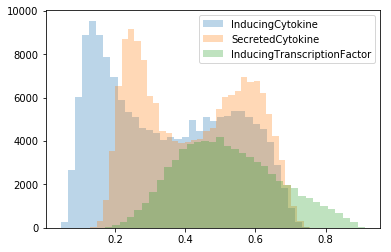

In [3]:
for c in res_pred:
    plt.hist(res_pred[c][1], label=c, bins=36, alpha=.3)
    plt.legend()

In [6]:
def to_record(cls, c, i, X, Y):
    assert len(X) == len(Y)
    candidate_class = classes[cls]
    typs = candidate_class.entity_types
    m1, m2 = {}, m_ct
    if typs[0] == ENT_TYP_CK.lower():
        m1 = m_ck
    elif typs[0] == ENT_TYP_TF.lower():
        m1 = m_tf
    else:
        raise ValueError('Type "{}" not supported'.format(typs[0]))
    ent1_cid = getattr(c, typs[0] + '_cid')
    ent2_cid = getattr(c, typs[1] + '_cid')
    doc_id = c.get_parent().get_parent().name
    return {
        'type': candidate_class.field, 
        'date': m_doc_dt.get(doc_id, None),
        'doc_id': doc_id, 
        'candidate_id': c.id, 
        'ent1_text': getattr(c, typs[0]).get_span(),
        'ent1_lbl': m1.get(ent1_cid.split(':')[1], None),
        'ent1_cid': ent1_cid, 
        'ent2_text': getattr(c, typs[1]).get_span(),
        'ent2_lbl': m2.get(ent2_cid.split(':')[1], None),
        'ent2_cid': ent2_cid,
        'prob': Y[i]
    }

df = pd.DataFrame([
    to_record(cls, cand, i, res_pred[cls][0], res_pred[cls][1]) 
    for cls in res_pred
    for i, cand in enumerate(res_pred[cls][0])
])
df.head()

candidate_id       date      doc_id                               ent1_cid  \
0         31923 2017-07-21  PMC5686050  CKAA6A3321D03ABD23:CK6FE135B3F86FB707   
1         31924 2017-07-21  PMC5686050  CKAA6A3321D03ABD23:CK6FE135B3F86FB707   
2         31925 2017-07-21  PMC5686050  CKAA6A3321D03ABD23:CK6FE135B3F86FB707   
3         31926 2017-07-21  PMC5686050  CKAA6A3321D03ABD23:CK6FE135B3F86FB707   
4         31927 2017-07-21  PMC5686050  CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707   

  ent1_lbl      ent1_text                               ent2_cid ent2_lbl  \
0     IL-4  interleukin-4  CTE7B12DC660323A0E:CTE7B12DC660323A0E      Th2   
1     IL-4  interleukin-4  CTC3A8C3CBC245616A:CTC3A8C3CBC245616A      Th1   
2     IL-4  interleukin-4  CTE7B12DC660323A0E:CTE7B12DC660323A0E      Th2   
3     IL-4  interleukin-4  CTC3A8C3CBC245616A:CTC3A8C3CBC245616A      Th1   
4     IL-4           IL-4  CTE7B12DC660323A0E:CTE7B12DC660323A0E      Th2   

  ent2_text      prob               type  
0       Th2  0.240373  inducing_cytokine  
1       Th1  0.605794  inducing_cytokine  
2       Th2  0.419859  inducing_cytokine  
3       Th1  0.648573  inducing_cytokine  
4       Th2  0.228279  inducing_cytokine

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396528 entries, 0 to 396527
Data columns (total 11 columns):
candidate_id    396528 non-null int64
date            396528 non-null datetime64[ns]
doc_id          396528 non-null object
ent1_cid        396528 non-null object
ent1_lbl        396528 non-null object
ent1_text       396528 non-null object
ent2_cid        396528 non-null object
ent2_lbl        396528 non-null object
ent2_text       396528 non-null object
prob            396528 non-null float64
type            396528 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 33.3+ MB


In [8]:
df['type'].value_counts()

inducing_cytokine                162226
secreted_cytokine                162226
inducing_transcription_factor     72076
Name: type, dtype: int64

In [9]:
df['ent2_lbl'].value_counts().sort_values().tail()

Th      17636
Th2     57605
Th1     66053
Treg    71925
Th17    84367
Name: ent2_lbl, dtype: int64

In [10]:
df['ent1_lbl'].value_counts().sort_values().tail()

IL-2     21716
IL-10    24844
TGF-β    28474
IL-4     30568
IFN-γ    45762
Name: ent1_lbl, dtype: int64

### Export 

In [17]:
df.to_csv(prediction_export_file, index=False)
prediction_export_file

'/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/export/prediction/candidates.csv'

## Load Predictions

Begin here if predictions already generated (which is often expensive):

In [128]:
df = pd.read_csv(prediction_export_file)
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396528 entries, 0 to 396527
Data columns (total 11 columns):
candidate_id    396528 non-null int64
date            396528 non-null datetime64[ns]
doc_id          396528 non-null object
ent1_cid        396528 non-null object
ent1_lbl        396528 non-null object
ent1_text       396528 non-null object
ent2_cid        396528 non-null object
ent2_lbl        396528 non-null object
ent2_text       396528 non-null object
prob            396528 non-null float64
type            396528 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 33.3+ MB


<hr>

## Analysis

### Highest/Lowest Probability Examples 

In [152]:
def get_sentence_html(c, p=None):
    text = c.get_parent().text
    ctx = sorted(c.get_contexts(), key=lambda v: v.char_start)
    c0 = ctx[0].char_start, ctx[0].char_end+1
    c1 = ctx[1].char_start, ctx[1].char_end+1
    assert c0[0] < c1[0] and c0[1] < c1[0]
    
    col1 = 'blue' if getattr(c, 'immune_cell_type') == ctx[0] else 'red'
    col2 = 'red' if col1 == 'blue' else 'blue'
    
    parts = []
    if p is not None:
        parts += ['<a style="background-color: white">{:.2f}%|&nbsp;</a>'.format(p*100)]
    parts += [
        text[:c0[0]], '<font color="' + col1 + '"><strong>' + text[c0[0]:c0[1]] + '</strong></font>',
        text[c0[1]:c1[0]], '<font color="' + col2 + '"><strong>' + text[c1[0]:c1[1]] + '</strong></font>',
        text[c1[1]:]
    ]
    return ''.join(parts)

In [64]:
# X, Y = res_pred['InducingCytokine'][:2]
# o = np.argsort(Y)[::-1]

In [153]:
from IPython.display import HTML, display

def get_prediction_html(index, X, Y, limit):
    html = []
    sent_ids = set()
    for i in index:
        sent_id = X[i].get_parent().id
        if sent_id in sent_ids:
            continue
        sent_ids.add(sent_id)
        html.append(get_sentence_html(X[i], p=Y[i]))
        if len(html) >= limit:
            break
    return HTML('<br>\n'.join(html))
    
n_cands, limit = 250, 10
res_pred_html = {}
for c in res_pred:
    X, Y = res_pred[c][:2]
    o = np.argsort(Y)
    res_pred_html[c] = {}
    
    display(HTML('<hr>'))
    print('%s (Top %s Highest Predictions):' % (c, limit))
    res_pred_html[c]['hi'] = get_prediction_html(o[::-1], X, Y, n_cands)
    display(get_prediction_html(o[::-1], X, Y, limit))
    
    display(HTML('<hr>'))
    print('%s (Mid %s Predictions):' % (c, limit))
    mid = len(o)//2
    res_pred_html[c]['mid'] = get_prediction_html(o[(mid-n_cands):(mid+n_cands)], X, Y, n_cands)
    display(get_prediction_html(o[(mid-n_cands):(mid+n_cands)], X, Y, limit))
    
    display(HTML('<hr>'))
    print('%s (Bottom %s Lowest Predictions):' % (c, limit))
    res_pred_html[c]['lo'] = get_prediction_html(o, X, Y, n_cands)
    display(get_prediction_html(o, X, Y, limit))

InducingCytokine (Top 10 Highest Predictions):


InducingCytokine (Mid 10 Predictions):


InducingCytokine (Bottom 10 Lowest Predictions):


SecretedCytokine (Top 10 Highest Predictions):


SecretedCytokine (Mid 10 Predictions):


SecretedCytokine (Bottom 10 Lowest Predictions):


InducingTranscriptionFactor (Top 10 Highest Predictions):


InducingTranscriptionFactor (Mid 10 Predictions):


InducingTranscriptionFactor (Bottom 10 Lowest Predictions):


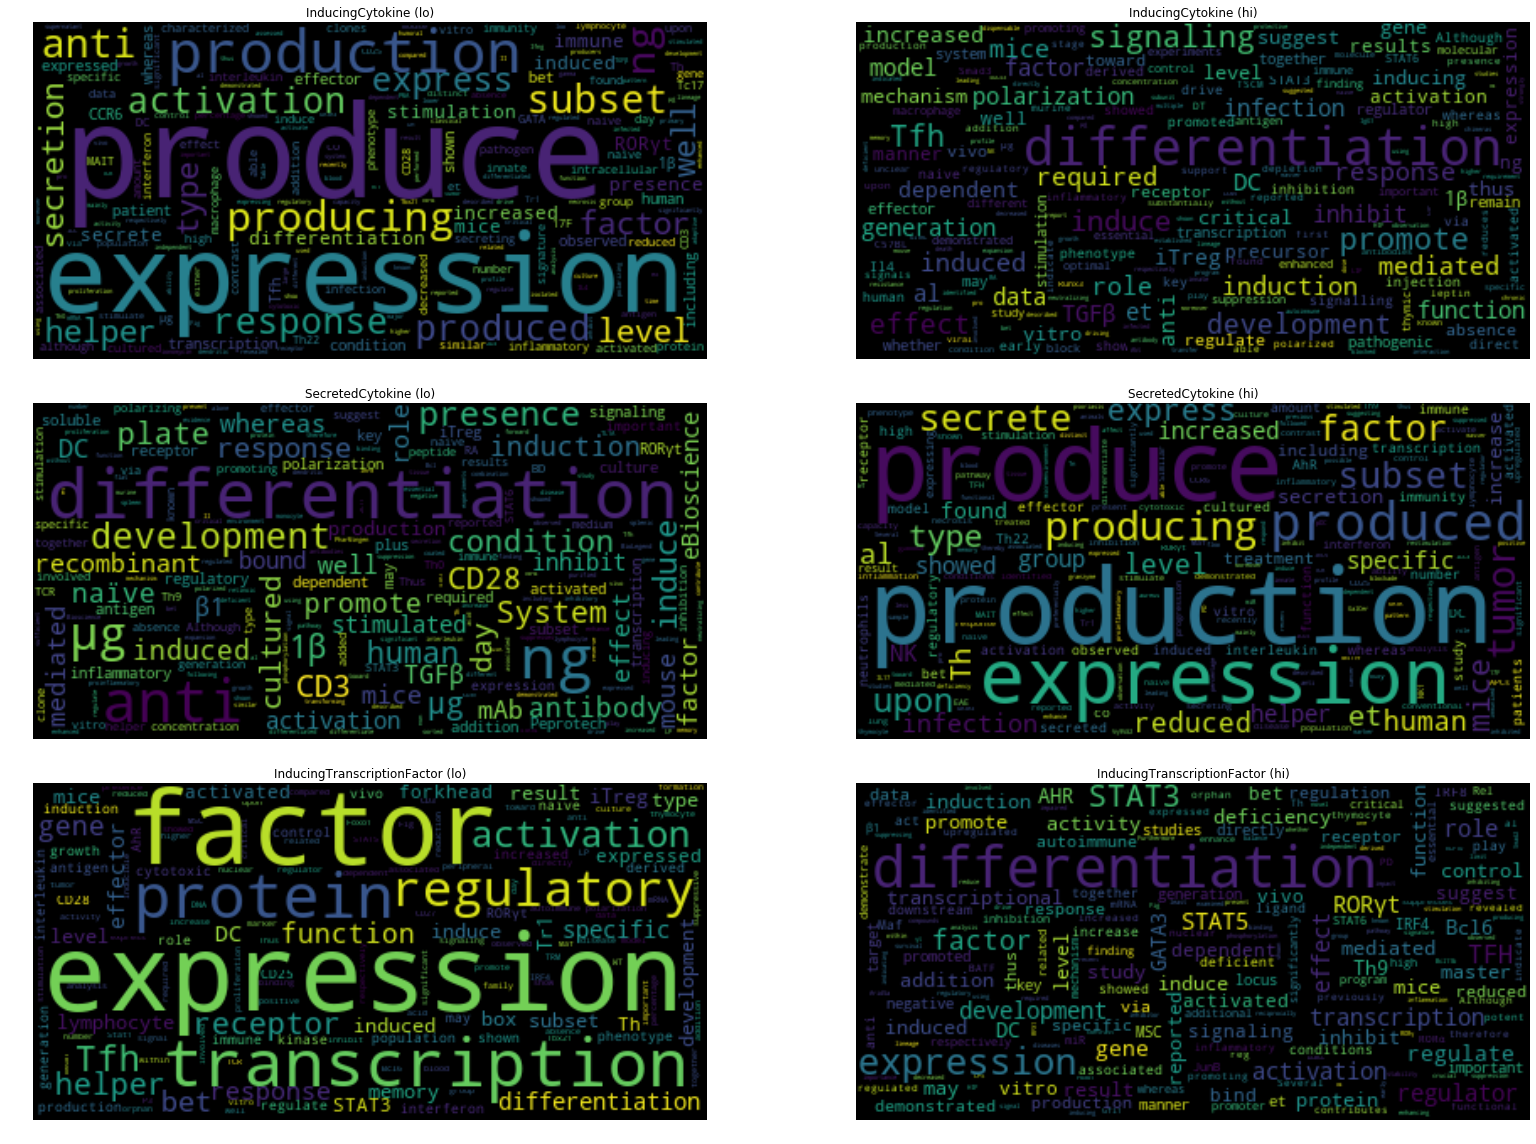

In [174]:
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import re
#keys = ['lo', 'mid', 'hi']
keys = ['lo', 'hi']
fig, axs = plt.subplots(len(res_pred_html), len(keys))
fig.set_size_inches(12*len(keys), 16)

WC_STOPWORDS = set(list(STOPWORDS) + [
    'cytokine', 'cell', 'cells', 'il', 'Th1', 'Th2', 'Th17', 'ml', 'nkt',
    'cytokines', 'foxp3', 'treg', 'tregs', 'ifn', 'cd4', 'ifnγ', 'γδ',
    'tnf', 'inkt', 'cd8',  'tgf', 'figure', '17a'
])
    
for i, c in enumerate(res_pred_html):
    def add_cloud(j, k):
        text = BeautifulSoup(res_pred_html[c][k].data).get_text()
        wordcloud = WordCloud(collocations=False, stopwords=WC_STOPWORDS, random_state=1).generate(text)    
        axs[i, j].imshow(wordcloud, interpolation='bilinear')
        axs[i, j].axis("off")
        axs[i, j].set_title(c + ' (' + k + ')')
    for j, k in enumerate(keys):
        add_cloud(j, k)
fig.tight_layout()

In [12]:
# from snorkel import viewer
# idx = np.argsort(Y)
# idx = idx[-100:]
# viewer.SentenceNgramViewer(
#     candidates=[X[i] for i in idx], 
#     session=session
# )

### Top Cytokines/TFs by Cell Type

"Enrichment Score": Proportion of papers for a cell type mentioning cytokine/TF divided by same proportion across all **other** cell types

In [78]:
def calculate_scores(df):
    
    def doc_ct(df):
        return df.groupby('ent1_lbl')['doc_id'].nunique().rename('uniq_doc_n')
    
    dfr = []
    for typ in df['type'].unique():
        for ct in df['ent2_lbl'].unique():
            df_tgt = df[(df['type'] == typ) & (df['ent2_lbl'] == ct)]
            df_ctx = df[(df['type'] == typ)]
            dfr.append(
                pd.merge(
                    # Unique doc counts for cell type (tgt) by cytokine/TF 
                    # as well as by cytokine/TF for all cell types (ctx)
                    doc_ct(df_ctx).rename('uniq_docn_ctx').reset_index(),
                    doc_ct(df_tgt).rename('uniq_docn_tgt').reset_index(),
                    on='ent1_lbl',
                    how='outer'
                )
                .fillna(0)
                .assign(
                    type=typ, ent2_lbl=ct,
                    # Unique doc count for cell type (tgt) and all cell types (ctx)
                    uniq_docn_ct_ctx=df_ctx['doc_id'].nunique(),
                    uniq_docn_ct_tgt=df_tgt['doc_id'].nunique()
                )
            )
    dfr = pd.concat(dfr, sort=False)
    assert dfr.notnull().all().all()
    dfr['escore'] = (dfr['uniq_docn_tgt'] / dfr['uniq_docn_ct_tgt']) / (dfr['uniq_docn_ctx'] / dfr['uniq_docn_ct_ctx'])
    return dfr
            

dfp = calculate_scores(df.query('prob > .5'))

dfp.head()

ent1_lbl  uniq_docn_ctx  uniq_docn_tgt               type ent2_lbl  \
0    4-1BB             21            6.0  inducing_cytokine      Th1   
1   4-1BBL              2            0.0  inducing_cytokine      Th1   
2    APRIL              7            2.0  inducing_cytokine      Th1   
3     CCL1             13            0.0  inducing_cytokine      Th1   
4    CCL11              8            1.0  inducing_cytokine      Th1   

   uniq_docn_ct_ctx  uniq_docn_ct_tgt    escore  
0              4276              2023  0.603912  
1              4276              2023  0.000000  
2              4276              2023  0.603912  
3              4276              2023  0.000000  
4              4276              2023  0.264212

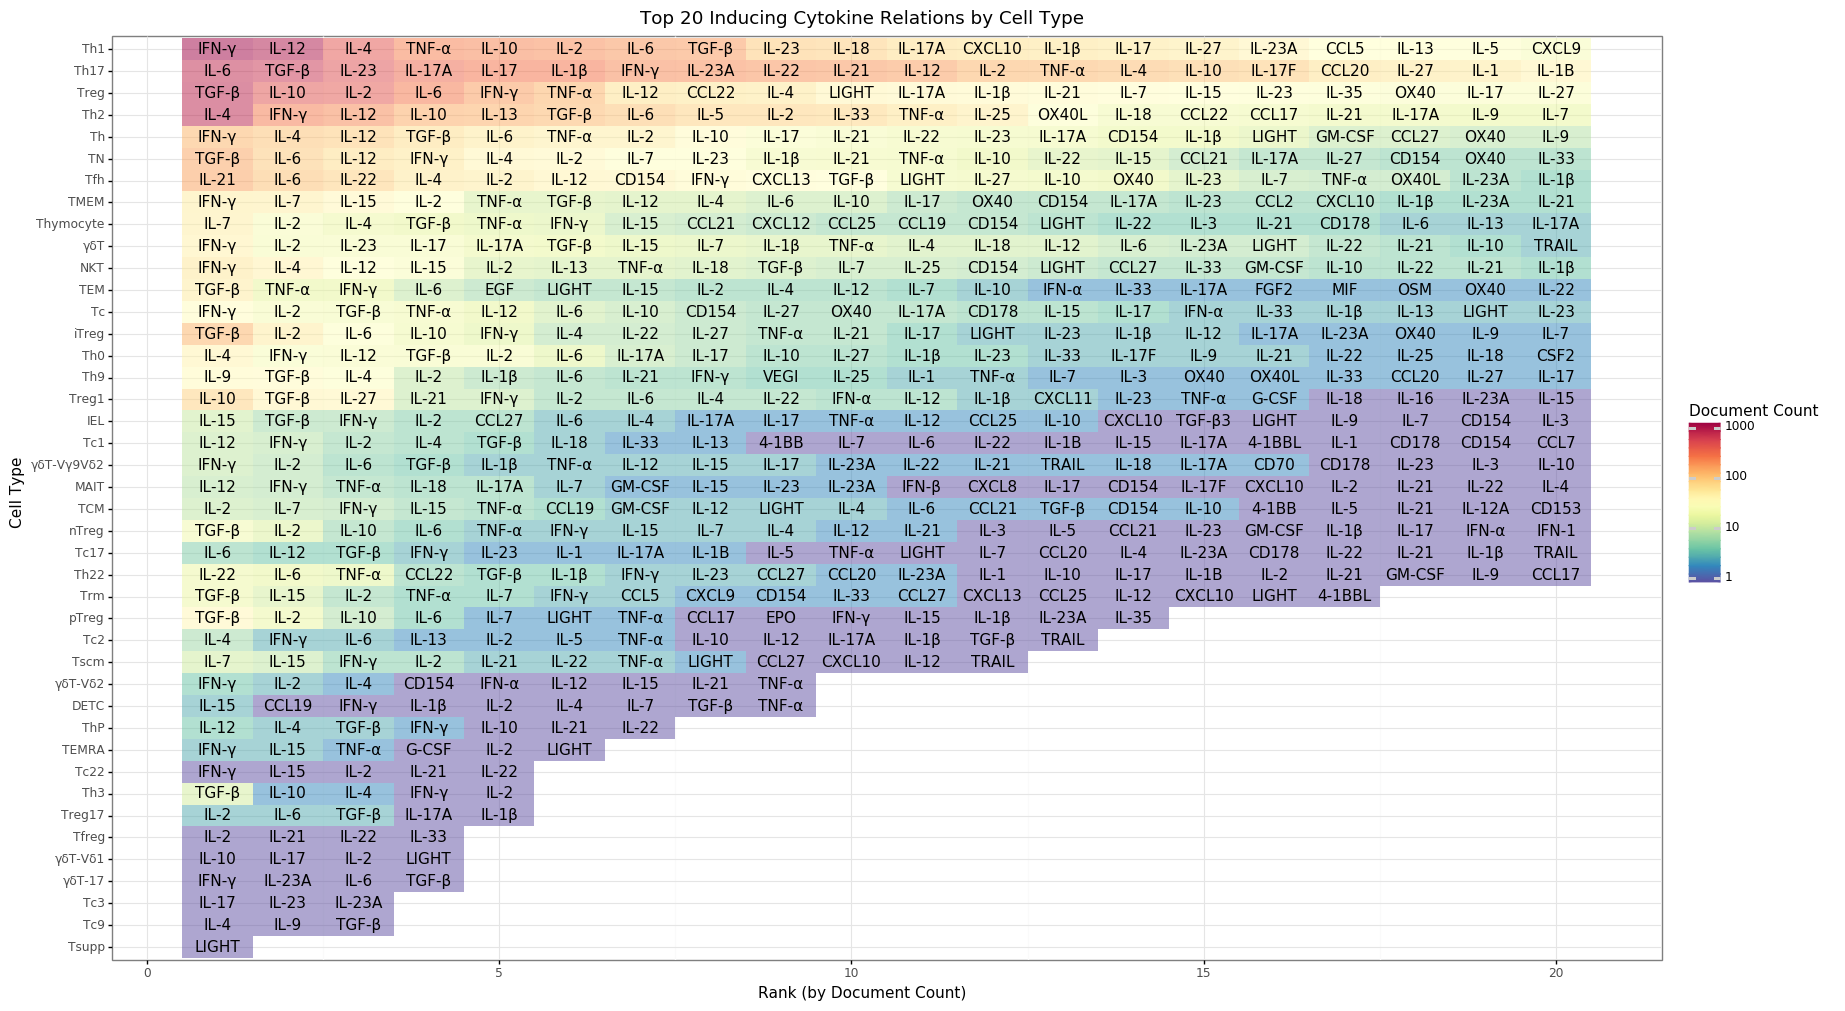

<ggplot: (-9223372036336089221)>

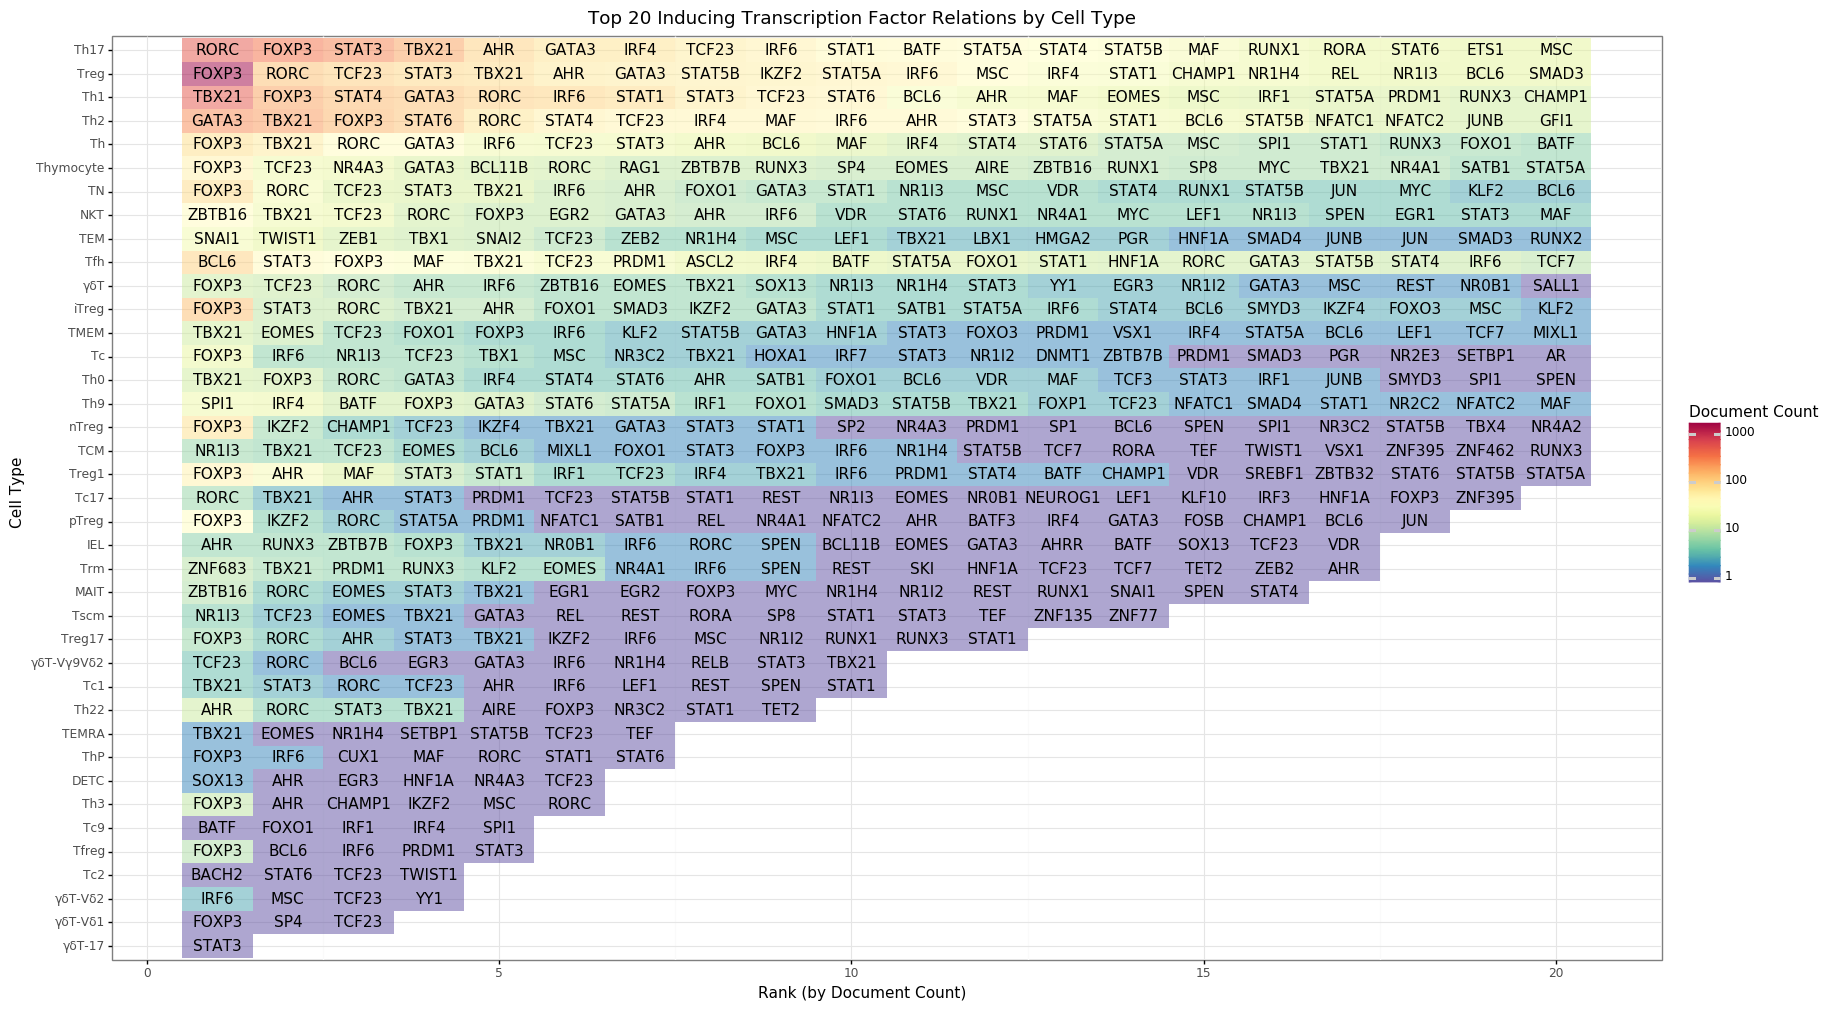

<ggplot: (519567024)>

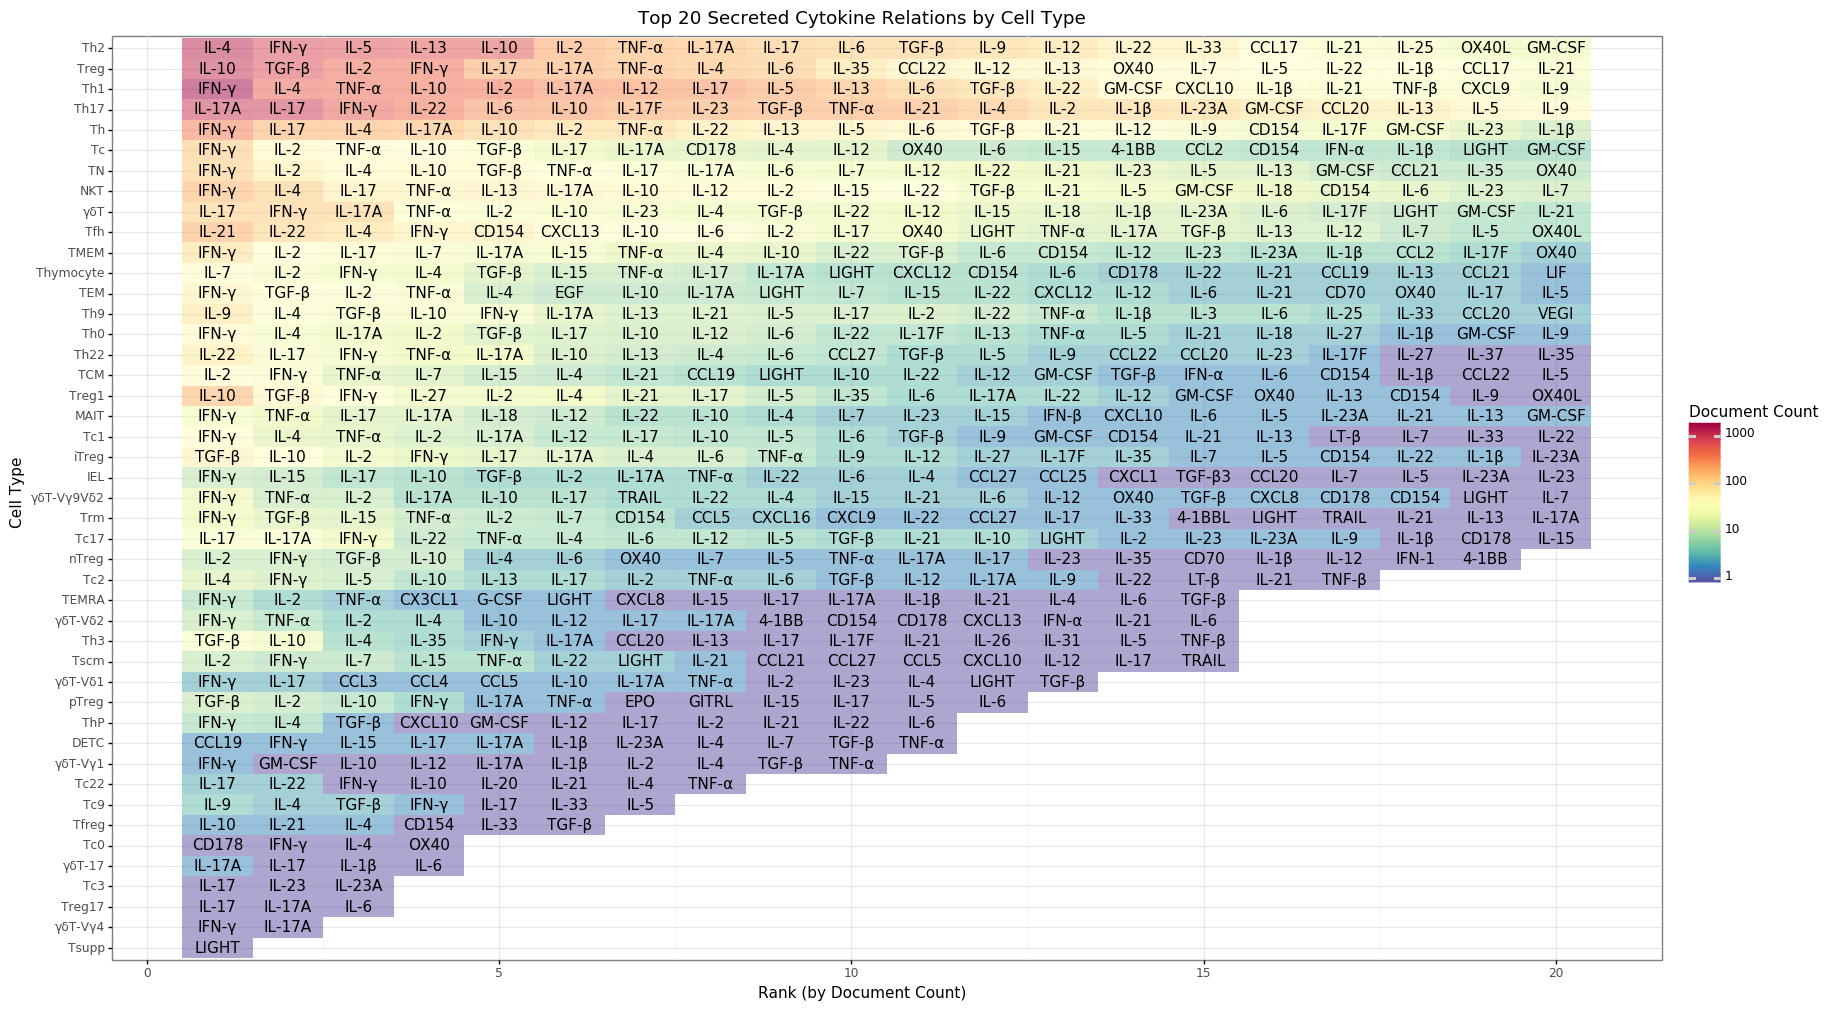

<ggplot: (-9223372036334361975)>

In [122]:
def get_labels(v):
    return [str(int(10**x)) for x in v]

for k, g in dfp.query('uniq_docn_tgt >= 1').groupby('type'):
    limit = 20
    p = (
        pn.ggplot(
            g
            .assign(uniq_docn_tgt_log=np.log10(g['uniq_docn_tgt']))
            .assign(ent2_lbl=lambda df: pd.Categorical(
                df['ent2_lbl'], categories=df.groupby('ent2_lbl').size().sort_values().index),
                ordered=True
            )
            .groupby('ent2_lbl').apply(
                lambda g: g.sort_values('uniq_docn_tgt_log', ascending=False)
                .assign(rank=np.arange(1, len(g)+1)).head(limit)
            ),
            pn.aes(x='rank', y='ent2_lbl', fill='uniq_docn_tgt_log', label='ent1_lbl')
        ) + 
        pn.geom_tile(alpha=.5) +
        pn.labs(
            title='Top {} {} Relations by Cell Type'.format(limit, k.replace('_', ' ').title()), 
            fill='Document Count', x='Rank (by Document Count)', y='Cell Type'
        ) +
        pn.scale_fill_cmap('Spectral_r', labels=get_labels) +
        pn.geom_text(color='black', alpha=1) +
        pn.theme_bw() + 
        pn.theme(figure_size=(20, 12))
    )
    display(p)

In [175]:
dfp.head()

ent1_lbl  uniq_docn_ctx  uniq_docn_tgt               type ent2_lbl  \
0    4-1BB             21            6.0  inducing_cytokine      Th1   
1   4-1BBL              2            0.0  inducing_cytokine      Th1   
2    APRIL              7            2.0  inducing_cytokine      Th1   
3     CCL1             13            0.0  inducing_cytokine      Th1   
4    CCL11              8            1.0  inducing_cytokine      Th1   

   uniq_docn_ct_ctx  uniq_docn_ct_tgt    escore  
0              4276              2023  0.603912  
1              4276              2023  0.000000  
2              4276              2023  0.603912  
3              4276              2023  0.000000  
4              4276              2023  0.264212

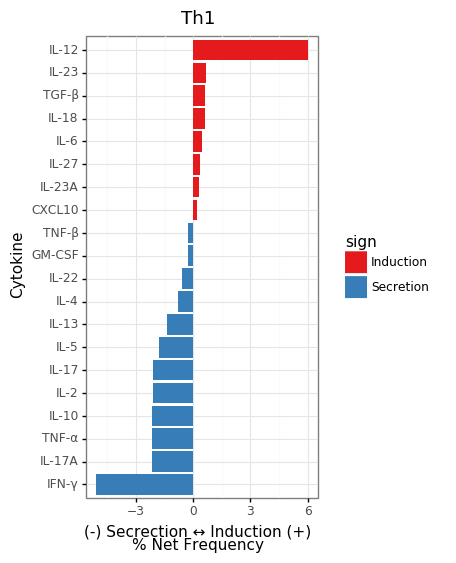

<ggplot: (509357874)>

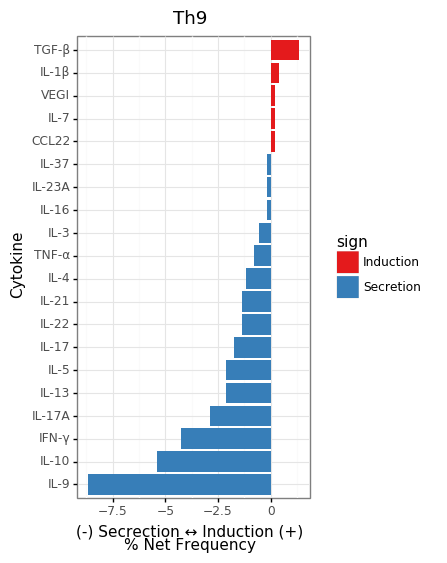

<ggplot: (510937576)>

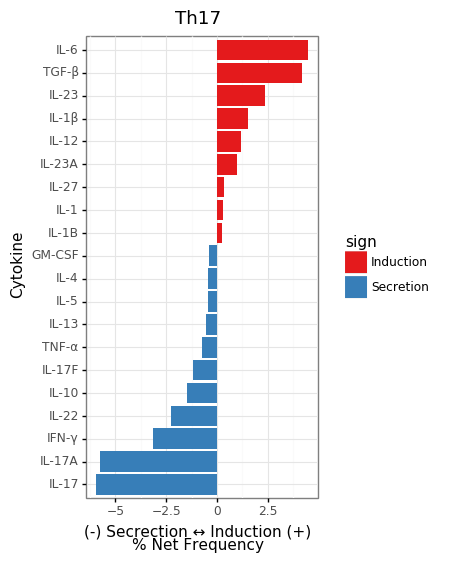

<ggplot: (-9223372036335195374)>

In [235]:
def plot_opposing(df, cell_type, limit=20):
    type_names = [classes.inducing_cytokine.field, classes.secreted_cytokine.field]
    df = df[df['type'].isin(type_names)].copy()
    df = df[df['ent2_lbl'] == cell_type].rename(columns={'uniq_docn_tgt': 'count'})
    df = df.pivot(index='ent1_lbl', columns='type', values='count')
    df = df.rename(columns=lambda c: c.replace('_cytokine', ''))
    total = df.sum().sum()
    cols = df.columns
    df['total'] = df.sum(axis=1)
    #df['score'] = ((df['inducing'] / df['total'])-.5) * (df['total']/total)
    df['score'] = 100 * ((df['inducing'] / total) - (df['secreted'] / total))
    df = df.reset_index().fillna(0)
    vals = df.set_index('ent1_lbl')['score'].abs().sort_values().tail(limit).index
    df = df[df['ent1_lbl'].isin(vals)]
    df['ent1_lbl'] = pd.Categorical(df['ent1_lbl'], categories=df.sort_values('score')['ent1_lbl'], ordered=True)
    df['sign'] = (df['score'] > 0).map({True: 'Induction', False: 'Secretion'})
    return (
        pn.ggplot(df, pn.aes(x='ent1_lbl', y='score', fill='sign')) +
        pn.geom_bar(stat='identity') + 
        pn.coord_flip() + 
        pn.theme_bw() + 
        pn.scale_fill_cmap_d('Set1') + 
        pn.labs(title=cell_type, y='(-) Secrection ↔ Induction (+)\n% Net Frequency', x='Cytokine') + 
        pn.theme(figure_size=(3, 6))
    )

display(plot_opposing(dfp, 'Th1'))
display(plot_opposing(dfp, 'Th9'))
display(plot_opposing(dfp, 'Th17'))

In [47]:
# for k, g in dfp.groupby('type'):
#     p = (
#         pn.ggplot(g, pn.aes(x='ent1_lbl', y='uniq_doc_ct')) + 
#         pn.geom_bar(stat='identity', alpha=.3) +
#         pn.facet_wrap('~ ent2_lbl', scales='free', ncol=3, shrink=False) + 
#         pn.labs(title=k) + 
#         pn.coord_flip() +
#         pn.theme_bw() +
#         pn.theme(
#             axis_text_x = pn.element_text(angle = 90, hjust = 0),
#             figure_size=(16, 24)
#         )
#     )
#     display(p)

## Specific Relationships

In [118]:
(
    dfp
    .pipe(lambda df: df[df['ent1_lbl'] == 'IL-32'])
    .query('uniq_docn_tgt > 0')
    .sort_values('escore', ascending=False)
)

ent1_lbl  uniq_docn_ctx  uniq_docn_tgt               type ent2_lbl  \
104    IL-32              4            1.0  inducing_cytokine      TEM   
104    IL-32              4            1.0  inducing_cytokine       Tc   
104    IL-32              6            2.0  secreted_cytokine       Tc   
104    IL-32              6            1.0  secreted_cytokine      TEM   
104    IL-32              6            2.0  secreted_cytokine      Th1   
104    IL-32              4            1.0  inducing_cytokine     Th17   
104    IL-32              4            1.0  inducing_cytokine      Th1   
104    IL-32              6            1.0  secreted_cytokine     Th17   
104    IL-32              6            1.0  secreted_cytokine      Th2   

     uniq_docn_ct_ctx  uniq_docn_ct_tgt    escore  
104              4276               120  8.908333  
104              4276               176  6.073864  
104              4498               309  4.852211  
104              4498               155  4.836559  
104              4498              2006  0.747424  
104              4276              1449  0.737750  
104              4276              2023  0.528423  
104              4498              1558  0.481172  
104              4498              1643  0.456279

In [114]:
from snorkel.models import Candidate
cand_ids = list(df[df['ent1_lbl'] == 'IL-32'].query('prob >= .5')['candidate_id'].unique())
np.array(cand_ids)

array([ 88745,  88796,  89086,  95335, 213927, 215156, 251138, 251140,
       251232, 251233, 251270, 252573, 113600, 115029, 115080, 115368,
       115369, 115370, 116335, 117667, 117668, 123185, 123186, 124532,
       315753, 334791, 365980, 366096, 366275, 367971, 367972, 368124])

In [116]:
cands = session.query(Candidate).filter(Candidate.id.in_([
88745,  88796,  89086,  95335, 213927, 215156, 251138, 251140,
251232, 251233, 251270, 252573, 113600, 115029, 115080, 115368,
115369, 115370, 116335, 117667, 117668, 123185, 123186, 124532,
315753, 334791, 365980, 366096, 366275, 367971, 367972, 368124
])).all()
cands[:3]

[InducingCytokine(Span("b'IL-32\xce\xb2'", sentence=612565, chars=[0,5], words=[0,0]), Span("b'cytotoxic T'", sentence=612565, chars=[36,46], words=[7,8])),
 InducingCytokine(Span("b'IL-32\xce\xb2'", sentence=612566, chars=[167,172], words=[26,26]), Span("b'cytotoxic T'", sentence=612566, chars=[63,73], words=[9,10])),
 InducingCytokine(Span("b'IL-32\xce\xb2'", sentence=612580, chars=[192,197], words=[33,33]), Span("b'cytotoxic T'", sentence=612580, chars=[273,283], words=[47,48]))]

In [120]:
from snorkel import viewer
viewer.SentenceNgramViewer(cands, session)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[1], [19], [17, 18]], [[20], [0, 2], [24, 25]], [[7, 21, 27, 28], [29, 30], [3]], […

### Evolution over Time

In [132]:
(df.query('prob > .5 & ent2_lbl == "Th17" & type == "inducing_cytokine"')
.groupby(['ent1_lbl', pd.Grouper(key='date', freq='1Q')])['doc_id'].nunique()
.rename('count').reset_index()
.head())

ent1_lbl       date  count
0    4-1BB 2012-06-30      1
1    4-1BB 2015-03-31      1
2    4-1BB 2019-03-31      1
3     CCL1 2016-12-31      1
4    CCL17 2010-06-30      1

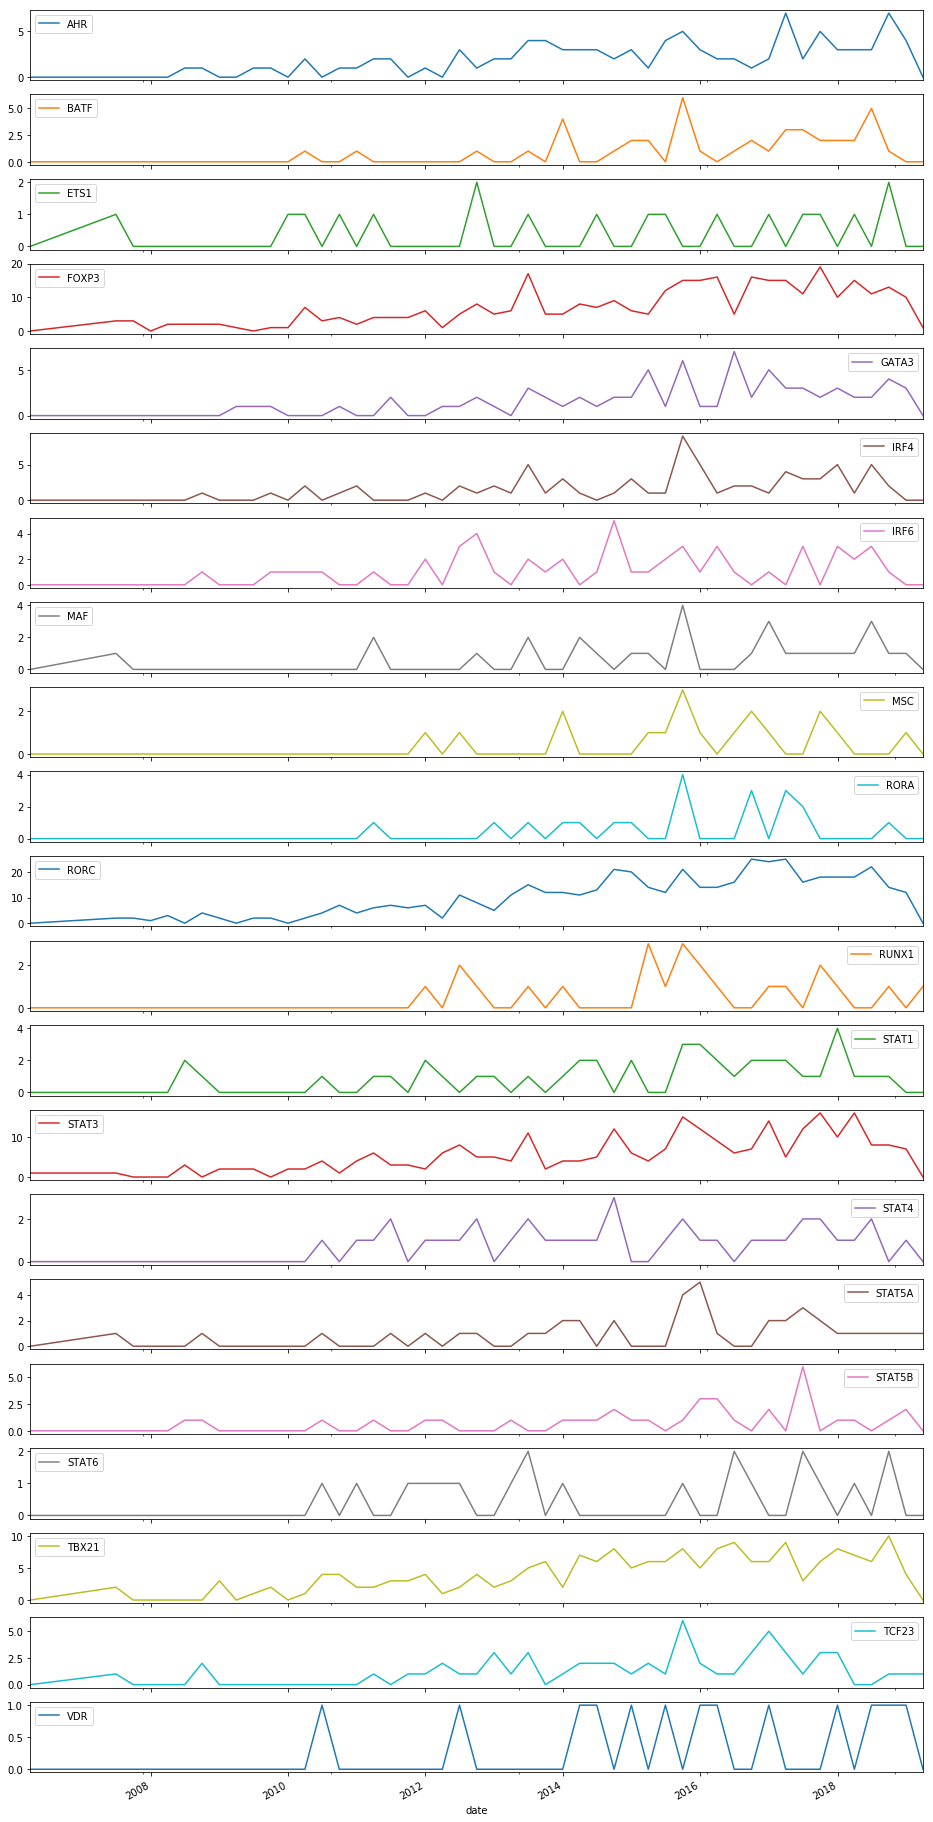

In [249]:
def remove_small_groups(df):
    # Get number of distinct dates for each cytokine/TF and limit
    # to remove those with sparse timelines
    cts = df.groupby('ent1_lbl').size() 
    return df[df['ent1_lbl'].isin(cts[cts > 10].index)]

(
    #df.query('prob > .5 & ent2_lbl == "Th17" & type == "secreted_cytokine"')
    #df.query('prob > .5 & ent2_lbl == "Th17" & type == "inducing_cytokine"')
    df.query('prob > .5 & ent2_lbl == "Th17" & type == "inducing_transcription_factor"')
    #df.query('prob > .5 & ent2_lbl == "γδT" & type == "secreted_cytokine"')
    .groupby(['ent1_lbl', pd.Grouper(key='date', freq='1Q')])['doc_id'].nunique()
    .rename('count').reset_index()
    .pipe(remove_small_groups)
    .pivot(index='date', columns='ent1_lbl', values='count')
    .fillna(0)
    .plot(figsize=(16,36), subplots=True, sharey=False)
)
None

### ImmuneXpresso Comparison

In [250]:
def get_ix_data():
    df = pd.read_csv(osp.join(os.environ['SUPERVISION_DATA_DIR'], 'immunexpresso', 'data.csv'))
    df['type'] = None
    df['type'] = np.where(
        (df['actor'] == 'cell') & (df['category'] == 'Positive'), 
        classes.secreted_cytokine.field, 
        df['type']
    )
    df['type'] = np.where(
        (df['actor'] == 'cytokine') & (df['category'] == 'Positive'), 
        classes.inducing_cytokine.field, 
        df['type']
    )
    return df[df['type'].notnull()]
df_ix = get_ix_data()
df_ix.head()

actor  category     cell_id                       cell_label  \
0      cell  Positive  CL_0000084                           T cell   
1      cell  Positive  CL_0000084                           T cell   
2      cell  Positive  CL_0000625  CD8-positive, alpha-beta T cell   
3  cytokine  Positive  CL_0000084                           T cell   
5      cell  Positive  CL_0000624  CD4-positive, alpha-beta T cell   

  cytokine_id cytokine_label  num_papers  score cell_ref_id  \
0      CID_83           IFNG         809   4.28         NaN   
1     CID_110            IL2         701   5.30         NaN   
2      CID_83           IFNG         338   8.88         NaN   
3     CID_110            IL2         313   1.58         NaN   
5      CID_83           IFNG         236   5.41         NaN   

      cytokine_ref_id               type  
0  CK128EC732B281BF60  secreted_cytokine  
1  CKD21834C7D75FD77F  secreted_cytokine  
2  CK128EC732B281BF60  secreted_cytokine  
3  CKD21834C7D75FD77F  inducing_cytokine  
5  CK128EC732B281BF60  secreted_cytokine

In [251]:
df_comp = pd.merge((
        df
        .query('prob > .5')
        .assign(ent1_cid=lambda df: df['ent1_cid'].str.split(':').str[1])
        .assign(ent2_cid=lambda df: df['ent2_cid'].str.split(':').str[1])
        .groupby(['type', 'ent1_cid', 'ent1_lbl', 'ent2_cid', 'ent2_lbl'])['doc_id'].nunique()
        .rename('n_docs_snkl').reset_index()
    ), (
        df_ix.groupby(['type', 'cell_ref_id', 'cytokine_ref_id'])['num_papers'].max()
        .rename('n_docs_imxp').reset_index()
        .rename(columns={'cytokine_ref_id': 'ent1_cid', 'cell_ref_id': 'ent2_cid'})
    ),
    on=['type', 'ent1_cid', 'ent2_cid'],
    how='outer'
)
df_comp.head()

type            ent1_cid ent1_lbl            ent2_cid  \
0  inducing_cytokine  CK07DD580A35CC46A7  IL-18BP  CTBFBDE5121B6748D1   
1  inducing_cytokine  CK07DD580A35CC46A7  IL-18BP  CTC3A8C3CBC245616A   
2  inducing_cytokine  CK07DD580A35CC46A7  IL-18BP  CTE7B12DC660323A0E   
3  inducing_cytokine  CK08F84BE8FE5B04F8   IL-17A  CT19D812F7CB34BCF6   
4  inducing_cytokine  CK08F84BE8FE5B04F8   IL-17A  CT1C58993C5B5BD3B8   

  ent2_lbl  n_docs_snkl  n_docs_imxp  
0     Th17          1.0          NaN  
1      Th1          3.0          NaN  
2      Th2          1.0          NaN  
3    iTreg          2.0          NaN  
4     TMEM          6.0          NaN

In [297]:
from scipy.stats import pearsonr

def plot_ix_comparison(rel_type):
    df = df_comp.dropna().copy()
    df = df[df['type'] == rel_type]
    r, p = pearsonr(df['n_docs_snkl'], df['n_docs_imxp'])
    if p < 1e-6:
        p = '< 1e-6'
    else:
        p = '= {:.6f}'.format(p)
    print('Num distinct cytokines:', df['ent1_lbl'].nunique())
    print('Num distinct cell types:', df['ent2_lbl'].nunique())
    print('Num distinct pairs:', len(df[['ent1_lbl', 'ent2_lbl']].drop_duplicates()))
    return (
        pn.ggplot(
            df, 
            pn.aes(x='n_docs_snkl', y='n_docs_imxp', color='ent2_lbl')
        ) + 
        pn.geom_point(size=3, alpha=.5) +
        pn.annotate('text', x=3, y=100, label='R = {:.2f} (p {})'.format(r, p)) + 
        pn.labs(
            title='ImmuneXpresso Comparison ({})'.format(rel_type.replace('_', ' ').title()),
            x='Document Count', y='ImmuneXpresso Document Count', color='Cell Type'
        ) + 
        pn.scale_x_log10() +
        pn.scale_y_log10() +
        pn.theme_bw() +
        pn.theme(figure_size=(8,6))
    )

Num distinct cytokines: 22
Num distinct cell types: 20
Num distinct pairs: 82


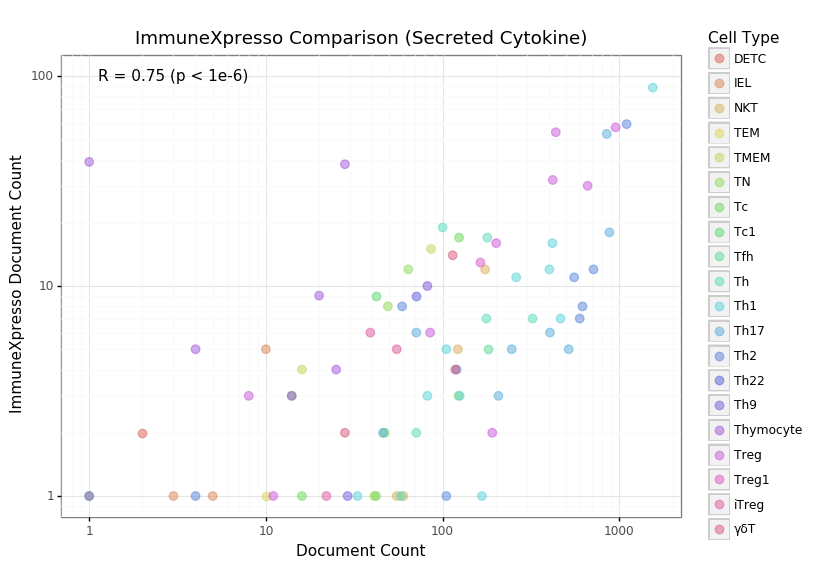

<ggplot: (-9223372036343860676)>

In [298]:
plot_ix_comparison(classes.secreted_cytokine.field)

Num distinct cytokines: 53
Num distinct cell types: 21
Num distinct pairs: 185


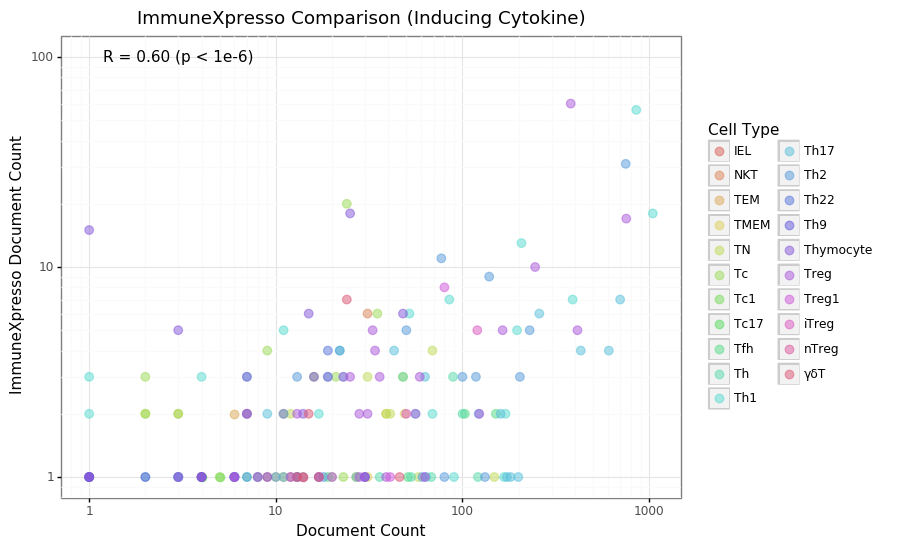

<ggplot: (-9223372036343850443)>

In [299]:
plot_ix_comparison(classes.inducing_cytokine.field)

In [170]:
# import seaborn as sns
# import scipy.stats as stats

# jg = sns.jointplot(
#     'n_docs_snkl', 'n_docs_imxp', 
#     #data=df_comp.dropna().query('type == "inducing_cytokine"'), 
#     data=df_comp.dropna().query('type == "secreted_cytokine"')
#     .assign(n_docs_snkl=lambda df: df['n_docs_snkl'].apply(np.log10))
#     .assign(n_docs_imxp=lambda df: df['n_docs_imxp'].apply(np.log10)), 
#     kind='reg', height=8
# )
# jg.annotate(stats.pearsonr)
# # jg.ax_joint.set_xscale('log')
# # jg.ax_joint.set_yscale('log')

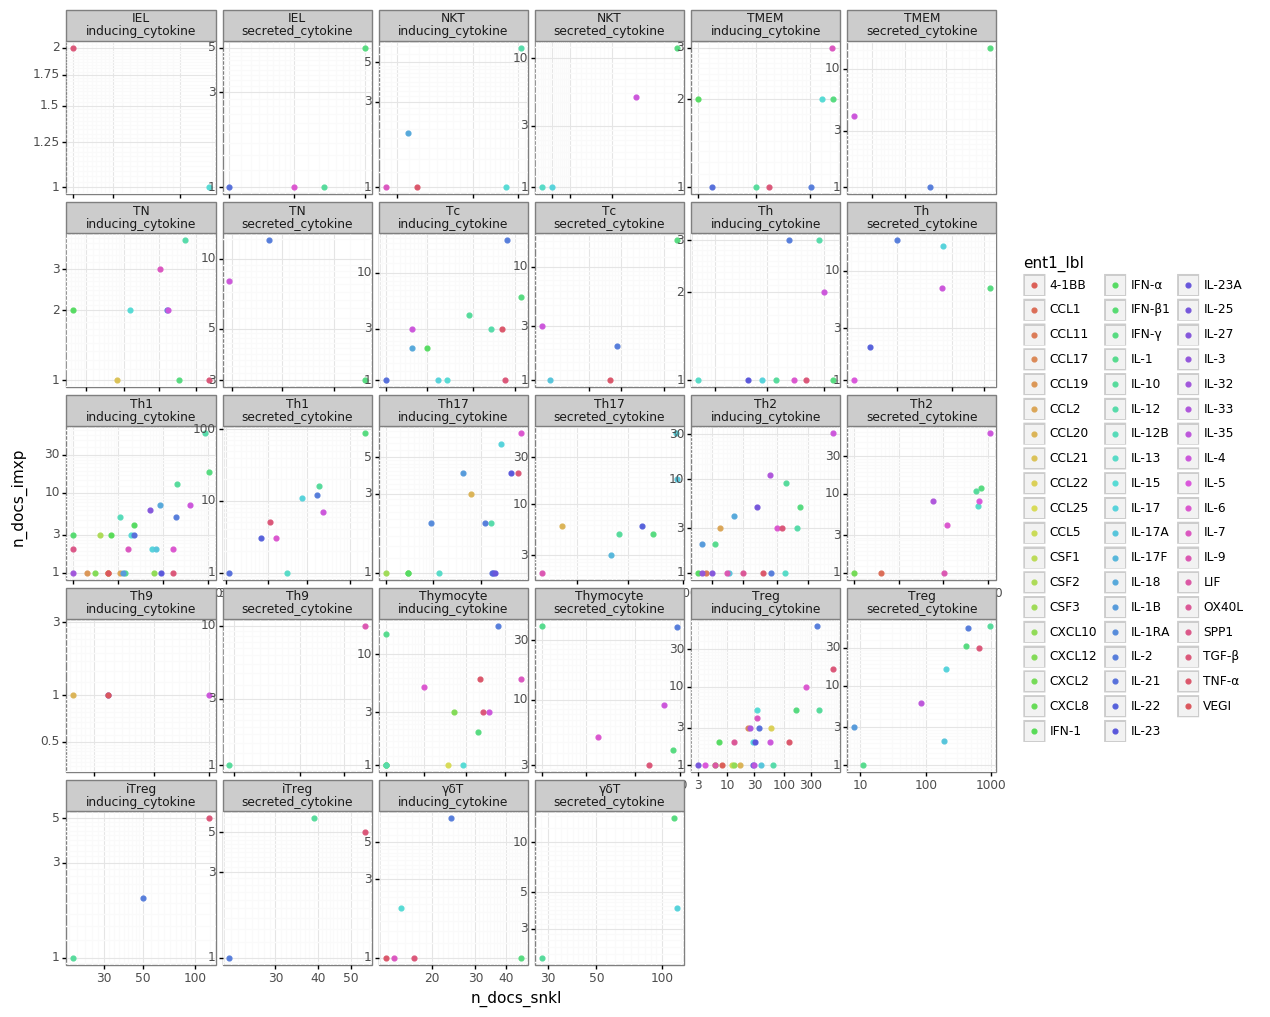

<ggplot: (-9223372036358487815)>

In [137]:
cts = df_comp.dropna().groupby('ent2_lbl').size() 
(
    pn.ggplot(
        df_comp.dropna().pipe(lambda df: df[df['ent2_lbl'].isin(cts[cts > 5].index)]), 
        pn.aes(x='n_docs_snkl', y='n_docs_imxp', color='ent1_lbl')
    ) + 
    pn.geom_point() + 
    pn.facet_wrap('~ ent2_lbl + type', scales='free') + 
    pn.scale_x_log10() +
    pn.scale_y_log10() +
    pn.theme_bw() +
    pn.theme(figure_size=(12,12))
)

### Export Candidates to BRAT

In [41]:
%run ../src/brat.py
collection_dir = osp.join(os.environ['REPO_DATA_DIR'], 'brat', 'viz', 'train_01')
corpus_docs_dir = osp.join(os.environ['DATA_DIR'], 'articles', 'corpus', 'corpus_00', 'links')
collection_dir, corpus_docs_dir

('/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/brat/viz/train_01',
 '/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/corpus/corpus_00/links')

<Figure size 432x288 with 0 Axes>

In [42]:
def relation_type_fn(c, i, ents):
    proba = Y[i] 
    if proba < .2:
        return c.type + '_low'
    if proba < .8:
        return c.type + '_mid'
    return c.type + '_high'

def text_loader_fn(doc_id):
    with open(osp.join(corpus_docs_dir, doc_id + '.txt')) as fd:
        return fd.read()

In [44]:
bcol = snorkel_candidates_to_brat_collection(
    X, candidate_class.subclass, text_loader_fn, relation_type_fn=relation_type_fn)

In [45]:
bcol.export(collection_dir, styles={
    candidate_class.field + '_low': 'color:red',
    candidate_class.field + '_mid': 'color:orange',
    candidate_class.field + '_high': 'color:green'
}, include_entity_text=False)